### [LLaMA 3](https://arxiv.org/pdf/2407.21783)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from dataclasses import dataclass

### Hyper Parameters

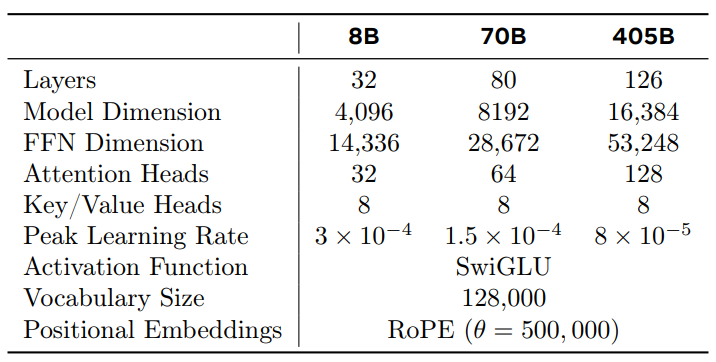

In [2]:
# define parameters smaller than the original LLaMA model
# to test simple training and inference

@dataclass
class ModelArgs:
    DIM = 128 # LLaMA: 4096
    FFN_DIM = 512 # LLaMA: 16384
    NUM_HEADS = 8 # LLaMA: 32
    NUM_LAYERS = 4 # LLaMA: 64

    NUM_KV_HEADS = 2 # LLaMA: 8
    VOCAB_SIZE = -1 # LLaMA: 128256 - decised by the tokenizer
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 500000, ROPER: 10000

    MAX_BATCH_SIZE = 8 # depending on the GPU memory
    MAX_SEQ_LEN = 12 # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = 0.1
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.set_default_tensor_type(torch.BFloat16Tensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [4]:
torch.set_default_dtype(torch.bfloat16)
torch.set_default_device(ModelArgs.DEVICE)

In [5]:
args = ModelArgs()
args

ModelArgs()

### RMSNorm

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)

### RoPE

In [7]:
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 10000.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)

def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor):
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

In [8]:
dummy_query = torch.randn(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.NUM_HEADS, args.HEAD_DIM, device=args.DEVICE)
dummy_kv = torch.randn(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.NUM_KV_HEADS, args.HEAD_DIM, device=args.DEVICE)

print("Query shape:", dummy_query.shape)
print("KV shape:", dummy_kv.shape)

Query shape: torch.Size([8, 12, 8, 16])
KV shape: torch.Size([8, 12, 2, 16])


In [9]:
dummy_query = apply_rotary_emb(dummy_query, precompute_freqs_cis(args.HEAD_DIM, args.MAX_SEQ_LEN, args.ROPE_THETA, args.DEVICE))
dummy_kv = apply_rotary_emb(dummy_kv, precompute_freqs_cis(args.HEAD_DIM, args.MAX_SEQ_LEN, args.ROPE_THETA, args.DEVICE))

print("Query shape after rotary emb:", dummy_query.shape)
print("KV shape after rotary emb:", dummy_kv.shape)

Query shape after rotary emb: torch.Size([8, 12, 8, 16])
KV shape after rotary emb: torch.Size([8, 12, 2, 16])


### FeedForward(SwiGLU)

- residual connection을 적용하는 방법이 달라짐
- 추가적으로 dropout을 적용했음

In [10]:
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

In [11]:
dummy_input = torch.randn(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.DIM, device=args.DEVICE)
ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT).to(args.DEVICE)
dummy_output = ffn(dummy_input)
print("FeedForward output shape:", dummy_output.shape)

FeedForward output shape: torch.Size([8, 12, 128])


### GQA with KV cache

In [12]:
# GQA with KV cache
class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        # KV Cache
        self.cache_k = torch.zeros(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, n_kv_heads, self.head_dim, device=args.DEVICE)
        self.cache_v = torch.zeros(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, n_kv_heads, self.head_dim, device=args.DEVICE)

    def forward(self, x: torch.Tensor, start_pos, freqs_cis: torch.Tensor, mask):
        B, L, _ = x.shape
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # apply position embedding
        xq = apply_rotary_emb(xq, freqs_cis)
        xk = apply_rotary_emb(xk, freqs_cis)
        
        # update cache        
        self.cache_k[:B, start_pos:start_pos+L] = xk
        self.cache_v[:B, start_pos:start_pos+L] = xv
        
        # GQA 
        # Qeury: [B, n_heads, L, head_dim] -> [B, L, n_heads, head_dim]
        xq = xq.transpose(1, 2)
        # Key & Value: [B, n_kv_heads, L, head_dim] -> [B, n_heads, L, head_dim] -> [B, L, n_heads, head_dim]
        xk = torch.repeat_interleave(xk, repeats=self.n_rep, dim=2).transpose(1, 2)
        xv = torch.repeat_interleave(xv, repeats=self.n_rep, dim=2).transpose(1, 2)
        
        out = F.scaled_dot_product_attention(xq, xk, xv, mask, self.attn_dropout)
        out = out.transpose(1, 2).contiguous().view(B, L, -1)
        return self.wo(out) # [B, L, D]

In [13]:
dummy_input = torch.randn(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.DIM, device=args.DEVICE)
dummy_mask = torch.ones(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.MAX_SEQ_LEN, device=args.DEVICE)
dummy_mask = torch.tril(dummy_mask)
dummy_mask[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')

In [14]:
dummy_start_pos = 0
dummy_freqs_cis = precompute_freqs_cis(args.HEAD_DIM, args.MAX_SEQ_LEN, args.ROPE_THETA, args.DEVICE)
attention = SelfAttention(args.NUM_HEADS, args.NUM_KV_HEADS, args.NUM_KV_HEAD_REP, args.DIM, args.DROPOUT).to(args.DEVICE)
dummy_output = attention(dummy_input, dummy_start_pos, dummy_freqs_cis, dummy_mask)
print("SelfAttention output shape:", dummy_output.shape)

SelfAttention output shape: torch.Size([8, 12, 128])


### Transformer Block

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.attention = SelfAttention(args.NUM_HEADS, args.NUM_KV_HEADS, args.NUM_KV_HEAD_REP, args.DIM, args.DROPOUT)
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
    def forward(self, x: torch.Tensor, start_pos, freqs_cis: torch.Tensor, mask):
        # [B, L, D]
        h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, freqs_cis, mask))
        o = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
        return o

In [16]:
dummy_input = torch.randn(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.DIM, device=args.DEVICE)
dummy_mask = torch.ones(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, args.MAX_SEQ_LEN, device=args.DEVICE)
dummy_mask = torch.tril(dummy_mask)
dummy_start_pos = 0
dummy_freqs_cis = precompute_freqs_cis(args.HEAD_DIM, args.MAX_SEQ_LEN, args.ROPE_THETA, args.DEVICE)
block = TransformerBlock(args).to(args.DEVICE)
dummy_output = block(dummy_input, dummy_start_pos, dummy_freqs_cis, dummy_mask)
print("TransformerBlock output shape:", dummy_output.shape)

TransformerBlock output shape: torch.Size([8, 12, 128])


### Transformer

In [17]:
class Transformer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.freqs_cis = precompute_freqs_cis(args.HEAD_DIM, args.MAX_SEQ_LEN, args.ROPE_THETA, args.DEVICE)
        
    def forward_train(self, x: torch.Tensor, start_pos):
        B, L = x.shape
        h = self.tok_embeddings(x) # [B, L, D]
        freqs_cis = self.freqs_cis[start_pos:start_pos+L]
        
        mask = None
        if L > 1:
            mask = torch.full((L, L), float('-inf'), device=args.DEVICE)
            mask = torch.triu(mask, 1, device=args.DEVICE)
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask) # [B, L, D]
        return self.output(self.norm(h)).float()
        
    @torch.inference_mode()
    def forward(self, x: torch.Tensor, start_pos):
        B, L = x.shape
        h = self.tok_embeddings(x) # [B, L, D]
        freqs_cis = self.freqs_cis[start_pos:start_pos+L]
        
        mask = None
        if L > 1:
            mask = torch.full((L, L), float('-inf'), device=args.DEVICE)
            mask = torch.triu(mask, 1).to(args.DEVICE)
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask) # [B, L, D]
        return self.output(self.norm(h)).float()

In [18]:
dummy_tokens = torch.rand(args.MAX_BATCH_SIZE, args.MAX_SEQ_LEN, device=args.DEVICE).long()
dummy_start_pos = 0

# define vocab size by the tokenizer
args.VOCAB_SIZE = 100
transformer = Transformer(args).to(args.DEVICE)
output = transformer(dummy_tokens, dummy_start_pos)
print("Transformer output shape:", output.shape)

Transformer output shape: torch.Size([8, 12, 100])
